#  Homework 2

## APMTH 207: Stochastic Methods for Data Analysis, Inference and Optimization

**Due Date: ** Thursday, Febrary 9th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Monte Carlo Integration

Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of $X$:

$$
h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}
$$

Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:
- inverse transform sampling
- rejection sampling with both uniform proposal distribution and normal proposal distribution (steroids) (with appropriately chosen parameters)
- importance sampling with both uniform proposal distribution and normal proposal distribution (with appropriately chosen parameters)


## Problem 1 Answer:

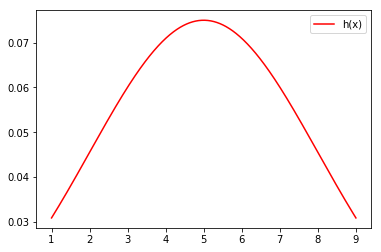

E[h(X)] - Inv.Trs.Spl: 0.466857846548
E[h(X)] - Rej.Spl: 0.468590148943
E[h(X)] - Rej.Spl.Std: 0.47337058318
E[h(X)] - Imp.Spl: 0.470175994431


In [50]:
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

def f(x):
    if x>=1 and x<=3:
        return (1.0/12.0)*(x-1)
    elif x>3 and x<=5:
        return (-1.0/12.0)*(x-5)
    elif x>5 and x<=7:
        return (1.0/6.0)*(x-5)
    elif x>7 and x<=9:
        return (-1.0/6.0)*(x-9)
    else:
        return 0

h = lambda X: (1.0/(3*np.sqrt(2)*np.pi))*np.exp((-1.0/18.0)*(X-5)**2)
N=1000
xmin = 1
xmax = 9
V = xmax - xmin

X = np.linspace(xmin, xmax, N)
plt.plot(X, h(X), 'r', label='h(x)')
plt.legend()
plt.show()

#============= Inverse Transform Sampling =============
cdf1 = lambda x : (1.0/12.0)*(1.0/2.0*x**2-x)
cdf2 = lambda x : (-1.0/12.0)*(1.0/2.0*x**2-5*x)
cdf3 = lambda x : (1.0/6.0)*(1.0/2.0*x**2-5*x)
cdf4 = lambda x : (-1.0/6.0)*(1.0/2.0*x**2-9*x)

# quantized CDFs
def CDF(x):
    if x>=1 and x<=3:
        return cdf1(x)-cdf1(1)
    elif x>3 and x<=5:
        return (cdf2(x)-cdf2(3))+(cdf1(3)-cdf1(1))
    elif x>5 and x<=7:
        return (cdf3(x)-cdf3(5))+(cdf2(5)-cdf2(3))+(cdf1(3)-cdf1(1))
    elif x>7 and x<=9:
        return (cdf4(x)-cdf4(7))+(cdf3(7)-cdf3(5))+(cdf2(5)-cdf2(3))+(cdf1(3)-cdf1(1))
    else:
        return 0
    
#  inverse CDP using interpolation
def invCDF(p,cdf,xs):
    i = np.searchsorted(cdf, p)
    if i>0:
        a = (p-cdf[i-1])/(cdf[i]-cdf[i-1])
        return xs[i-1] + a*(xs[i]-xs[i-1])
    return xs[i]

def inv_trs_spl():
    
    # calculate CDFs
    xs = np.linspace(xmin, xmax, N)
    cdf = np.zeros(N)
    for i,x in enumerate(xs):
        cdf[i] = CDF(x)

    # sample x using inverse CDP
    ps = np.random.uniform(low=0, high=1, size=N) 
    X = np.sort(np.array([invCDF(p, cdf, xs) for p in ps]))
    
    return V*np.sum(h(X))/N

print 'E[h(X)] - Inv.Trs.Spl:', inv_trs_spl()

#============= Rejection Sampling =============
def rej_spl():
    X = np.zeros(N)
    accepted = 0
    count = 0
    ymax = 1/3.0
    while (accepted<N):
        x = np.random.uniform(low=1, high=9)
        y = np.random.uniform(low=0,high=ymax)
        if y<f(x):
            X[accepted] = x
            accepted+=1
        count+=1
    return V*np.sum(h(X))/N

print 'E[h(X)] - Rej.Spl:',rej_spl()

def rej_spl_std():
    mu = 7.0
    sig = 3.5
    X = np.zeros(N)
    accepted = 0
    count = 0
    ymax = 1/3.0
    while (accepted<N):
        x = np.random.normal(mu,sig)
        y = np.random.uniform(low=0,high=ymax)
        if y<f(x)/(3*stats.norm.pdf(x, mu,sig)):
            X[accepted] = x
            accepted+=1
        count+=1
    return V*np.sum(h(X))/N

print 'E[h(X)] - Rej.Spl.Std:',rej_spl_std()


#============= Importance Sampling =============

X = np.linspace(xmin, xmax, N)
mu = 5.0
sig = 5.0
g = lambda x: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(x-mu)**2/(2.0*sig**2))
normfun = lambda x:  norm.cdf(x-mu, scale=sig)

def imp_spl():
    # draw from gaussian
    X = np.zeros(N)
    accepted = 0
    while accepted<N:
        x = np.random.normal(mu,sig)
        if (x<xmax) and (x>xmin):
            X[accepted] = x
            accepted+=1
    normal = normfun(xmax)-normfun(xmin);
    return np.mean(h(X)/g(X))*normal;

print 'E[h(X)] - Imp.Spl:', inv_trs_spl()



## Problem 2: Variance Reduction

### Part A

Compute the variance of each estimate of $\mathbb{E}[h(X)]$ obtained in Problem 1. Based on the discussion on sampling methods in lecture, which sampling methods, proposal distributions is expected, in principle, to resulted in lower variances? How well do your results align with these expectations?

### Part B (Stratified Sampling)

Often, a complex integral can be computed with more ease if one can break up the domain of the integral into pieces and if on each piece of the domain the integral is simplified. 

- Find a natural way to divide the domain of $X$ and express $\mathbb{E}[h(X)]$ as an ***correctly*** weighted sum of integrals over the pieces of the domain of $X$. (This constitutes the essentials of Stratified Sampling)

- Estimate each integral in the summand using rejection sampling using a normal proposal distribution (with sensibly chosen parameters). From these, estimate $\mathbb{E}[h(X)]$.

- Compute the variance of your estimate of $\mathbb{E}[h(X)]$. Compare with the variance of your previous estimate of $\mathbb{E}[h(X)]$ (in Part A, using rejection sampling, a normal proposal distribution over the entire domain of $X$).

Read more about Stratified Sampling:

1. [Variance Reduction Techniques Slides](http://www.sta.nus.edu.sg/~zhangjt/teaching/ST4231/lectures/chapter4.pdf)

2. [Monte Carlo Methods](http://www.public.iastate.edu/~mervyn/stat580/Notes/s09mc.pdf)

3. [Variance Reduction Techniques Chapter](http://sas.uwaterloo.ca/~dlmcleis/s906/chapt4.pdf)

## Part A Answer:

In [51]:

m=1000
inv = np.zeros(m)
rej = np.zeros(m)
rej_std = np.zeros(m)
imp = np.zeros(m)

for i in np.arange(m):
    if i%100==0:
        print 'progress',i
    inv[i] = inv_trs_spl()
    rej[i] = rej_spl()
    rej_std[i] = rej_spl_std()
    imp[i] = imp_spl()

print 'Inv.Trs.Spl:', np.mean(inv), np.std(inv)
print 'Rej.Spl:', np.mean(rej), np.std(rej)
print 'Rej.Spl.Std:', np.mean(rej_std), np.std(rej_std)
print 'Imp.Spl:', np.mean(imp), np.std(imp)

progress 0
progress 100
progress 200
progress 300
progress 400
progress 500
progress 600
progress 700
progress 800
progress 900
Inv.Trs.Spl: 0.470778582603 0.00250646452828
Rej.Spl: 0.470734863356 0.00254518341794
Rej.Spl.Std: 0.472150491334 0.0029881709536
Imp.Spl: 0.461331675352 0.0022357633489


The importance sampling has the lowest variance as expected, while the rejection sampling has the highest variance. It makes sense as importance sampling tries to draw more samples where h(x) is large. Inverse transform sampling also attempts to sample high-mass regions by using the inverse cumulative distribution function. On the other hand, rejection sampling does not differentiate between high-mass and low-mass regions, resulting in the largest variance.

## Part B Answer:

In [53]:
def xsamples(Umin,Umax, N):
    mu = 7.0
    sig = 3.5
    X = np.zeros(N)
    accepted = 0
    ymax = 1/3.0
    while (accepted<N):
        x = np.random.normal(mu,sig)
        y = np.random.uniform(low=0,high=ymax)
        if (x<Umax) and (x>Umin) and y<f(x)/(3*stats.norm.pdf(x, mu,sig)):
            X[accepted] = x
            accepted+=1
    return X

def stf_spl():
    Ns = 4
    step = (xmax - xmin)/Ns
    Umin = 0 
    Umax = step
    total = 0
    for j in np.arange(Ns):
        X = xsamples(Umin, Umax, N/Ns)#np.random.uniform(low=Umin, high=Umax, size = N/Ns)        
        total = total + (Umax - Umin)* np.mean(h(X))
        Umin = Umin + step
        Umax = Umin + step
    return total

stf = np.zeros(m)
for i in np.arange(m):
    if i%100==0:
        print 'progress',i
    stf[i] = stf_spl()
    


print 'Stf.Spl:', np.mean(stf), np.std(stf)
    

progress 0
progress 100
progress 200
progress 300
progress 400
progress 500
progress 600
progress 700
progress 800
progress 900
Stf.Spl: 0.466098906157 0.00137007929693


The variance is about twice lower than the previous one without using the stratification.